In [1]:
# Notebook imports
import os
import sys
import copy
import logging
import time
import json
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from esat.data.datahandler import DataHandler
from esat.model.sa import SA
from esat.model.batch_sa import BatchSA
from esat.data.analysis import ModelAnalysis
from eval.factor_comparison import FactorComp

In [3]:
profile_compare_file = os.path.join("..", "eval", "results", "pc_analysis_2024.json")

profile_json = {}
with open(profile_compare_file, 'r') as p_file:
    profile_json = json.load(p_file)

In [4]:
import pandas as pd
import numpy as np

## Comparative Analysis

The ESAT solution analysis consists of a factor profile/contribution comparison, a loss value comparison, and a runtime comparison.

The factor comparison is a solution comparison between ESAT and PMF5. For the sample datasets and a factor count ranging from 3 to 9, 100 models were created for both ESAT algorithms. The factor profile for each of those models were mapped to the optimal PMF5 output of the same dataset/factor solution, with a 1-to-1 mapping of factors by highest correlation $R^2$ between them. The model with the highest average $R^2$ for the mapped factors was used and the factor contributions $R^2$ was calculated using the same factor mapping. Factor mapping is required because the order that factors occur in the H/W matrix is not fixed. The final solution of slightly different initial H/W matrices could be very similar but the factors in completely different orders. The purpose of this comparison is to demonstrate that ESAT is capable of producing a solution that is highly comparable to PMF5 while the loss values are nearly the same.

The loss value comparison looks at the lowest


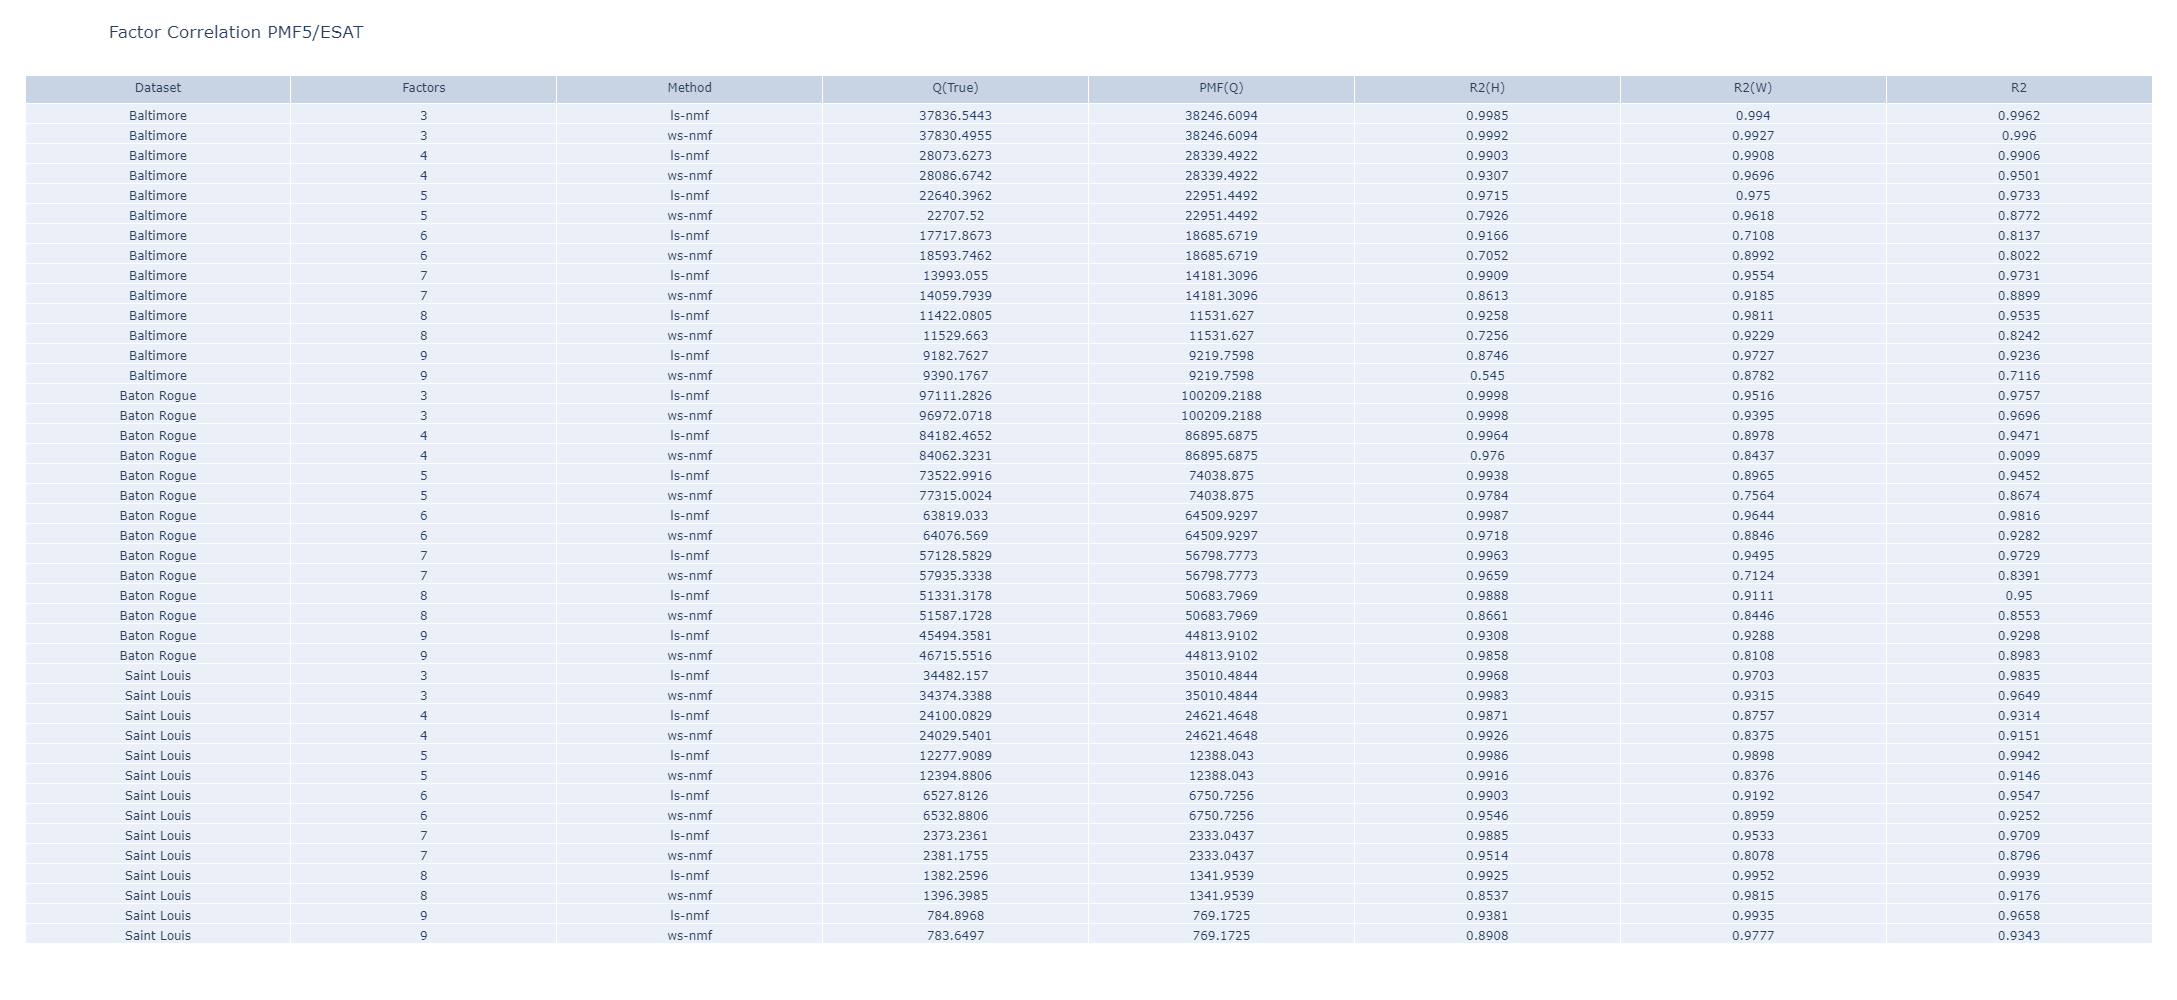

In [5]:
q_df = pd.DataFrame(profile_json.values())
q_df["dataset"] = q_df["dataset"].replace({"br": "Baton Rogue", "b": "Baltimore", "sl": "Saint Louis"})
q_df["R2(H)"] = q_df["model_profile_r2"]
q_df["R2(W)"] = q_df["model_contribution_r2"]
q_df["R2"] = (q_df["R2(W)"] + q_df["R2(H)"]) / 2.0
# q_df.rename(columns={"Q(ls-nmf-R2)": "R2(ls-nmf)", "Q(ws-nmf-R2)": "R2(ws-nmf)"}, inplace=True)
select_columns = ["dataset", "factors", "method", "Q(True)", "PMF(Q)", "R2(H)", "R2(W)", "R2"]
labeled_columns = ["Dataset", "Factors", "Method", "Q(True)", "PMF(Q)", "R2(H)", "R2(W)", "R2"]
q_df = q_df[select_columns]
q_df = q_df.round(decimals=4)
q_df = q_df.drop(q_df[q_df["factors"]==10].index)

q_table = go.Figure(data=[go.Table(header=dict(values=labeled_columns), cells=dict(values=q_df[select_columns].T))])
q_table.update_layout(width=1200, height=1000, margin=dict(l=25, r=25, t=75, b=25), title="Factor Correlation PMF5/ESAT")
q_table.show()

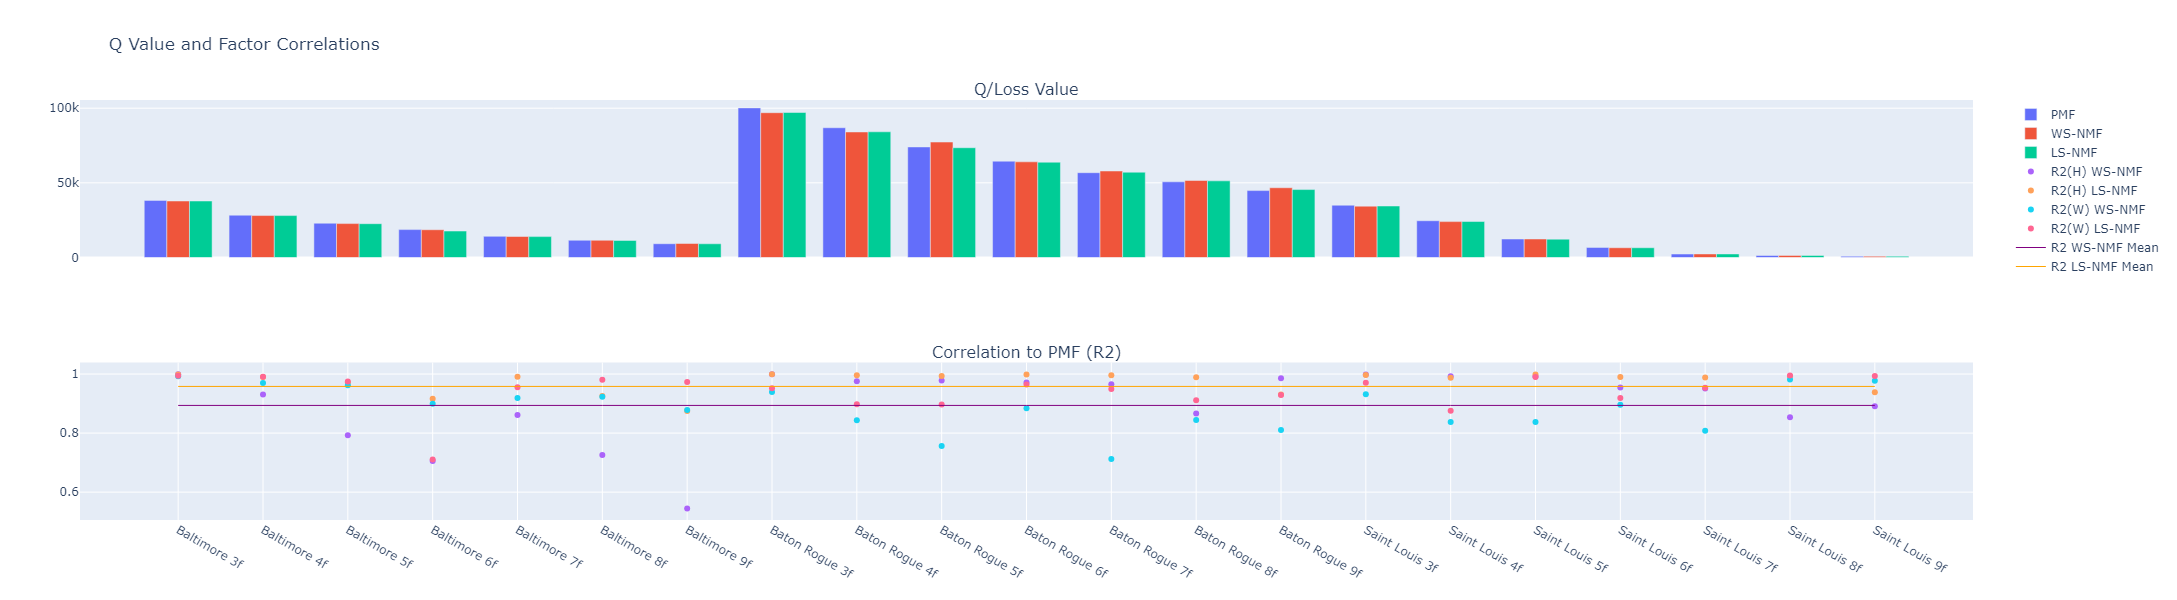

In [6]:
labels = q_df.loc[q_df["method"]=="ws-nmf"]["dataset"] + " " + q_df.loc[q_df["method"]=="ws-nmf"]["factors"].astype(str) + "f"
q_df["index"] = labels

q_sub = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Q/Loss Value", "Correlation to PMF (R2)"))

pmf_trace = go.Bar(x=labels, y=q_df.loc[q_df["method"]=="ws-nmf"]["PMF(Q)"], name="PMF")
ws_trace = go.Bar(x=labels, y=q_df.loc[q_df["method"]=="ws-nmf"]["Q(True)"], name="WS-NMF")
ls_trace = go.Bar(x=labels, y=q_df.loc[q_df["method"]=="ls-nmf"]["Q(True)"], name="LS-NMF")
q_sub.add_trace(pmf_trace, 1, 1)
q_sub.add_trace(ws_trace, 1, 1)
q_sub.add_trace(ls_trace, 1, 1)

ws_trace2 = go.Scatter(x=labels, y=q_df.loc[q_df["method"]=="ws-nmf"]["R2(H)"], name="R2(H) WS-NMF", mode='markers')
ls_trace2 = go.Scatter(x=labels, y=q_df.loc[q_df["method"]=="ls-nmf"]["R2(H)"], name="R2(H) LS-NMF", mode='markers')
ws_trace3 = go.Scatter(x=labels, y=q_df.loc[q_df["method"]=="ws-nmf"]["R2(W)"], name="R2(W) WS-NMF", mode='markers')
ls_trace3 = go.Scatter(x=labels, y=q_df.loc[q_df["method"]=="ls-nmf"]["R2(W)"], name="R2(W) LS-NMF", mode='markers')
ws_mean2 = go.Scatter(x=labels, y=[q_df.loc[q_df["method"]=="ws-nmf"]["R2"].mean()] * len(labels), name="R2 WS-NMF Mean", mode='lines', line=dict(width=1, color='purple'))
ls_mean2 = go.Scatter(x=labels, y=[q_df.loc[q_df["method"]=="ls-nmf"]["R2"].mean()] * len(labels), name="R2 LS-NMF Mean", mode='lines', line=dict(width=1, color='orange'))

q_sub.add_trace(ws_trace2, row=2, col=1)
q_sub.add_trace(ls_trace2, row=2, col=1)
q_sub.add_trace(ws_trace3, row=2, col=1)
q_sub.add_trace(ls_trace3, row=2, col=1)
q_sub.add_trace(ws_mean2, row=2, col=1)
q_sub.add_trace(ls_mean2, row=2, col=1)

q_sub.update_layout(height=600, width=1200, title_text="Q Value and Factor Correlations", hovermode="x")
q_sub.show()

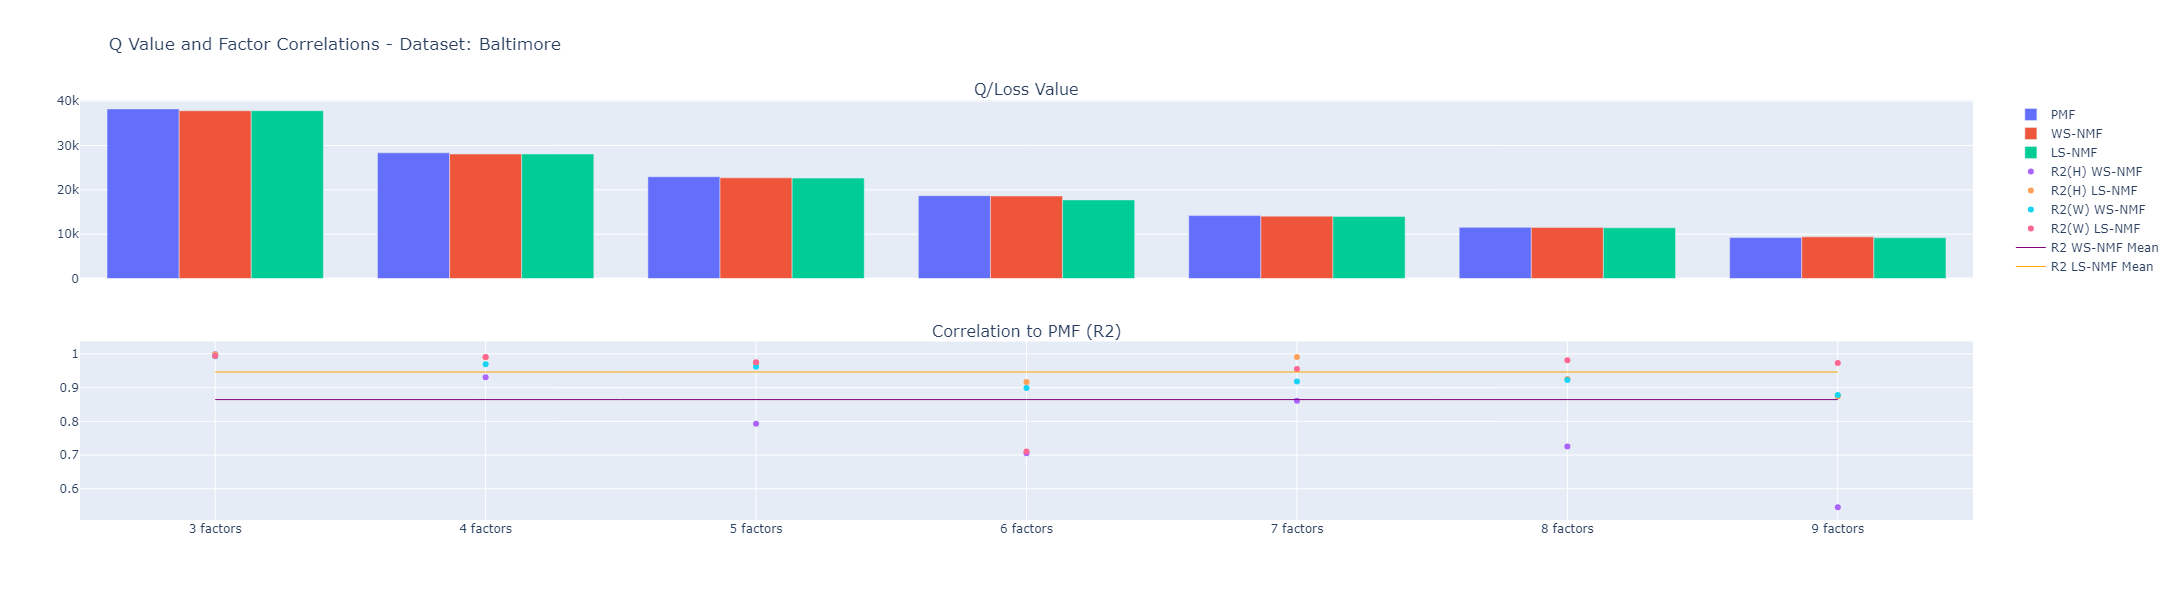

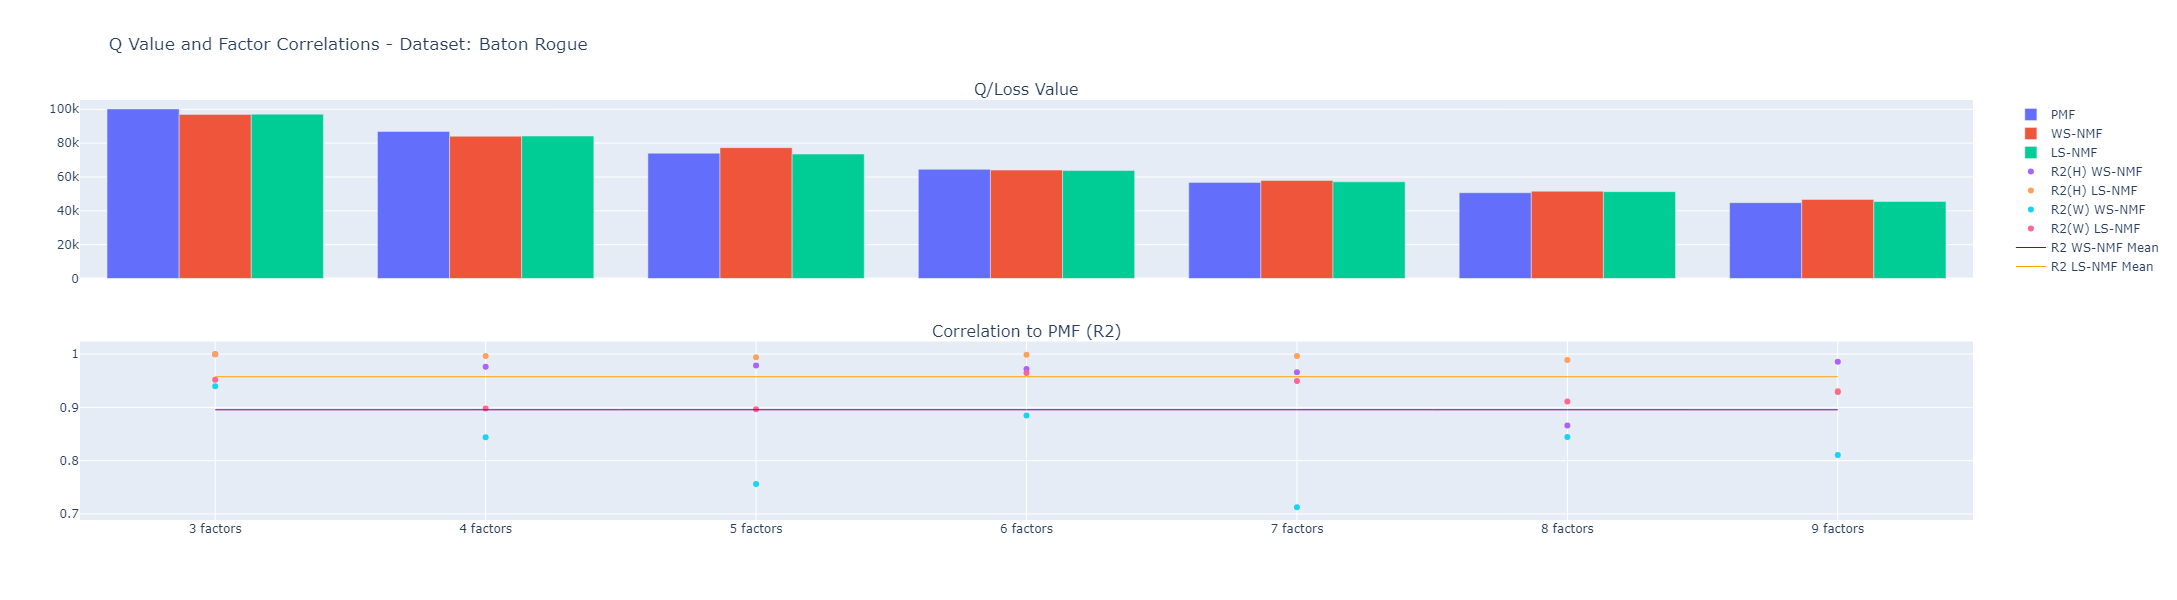

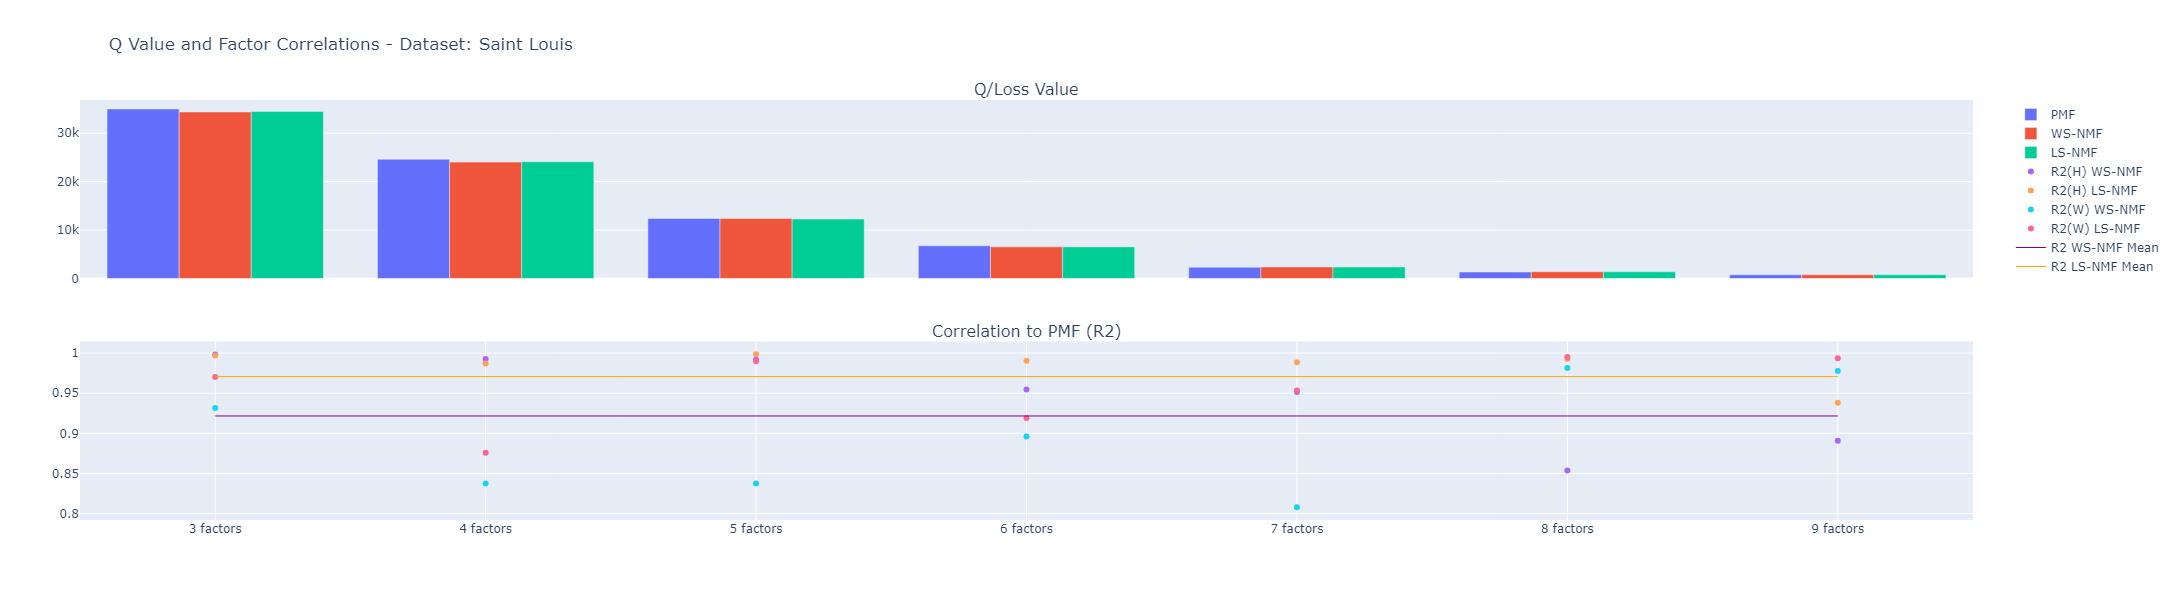

In [7]:
for dataset in ["Baltimore", "Baton Rogue", "Saint Louis"]:
    i_df = q_df.loc[q_df["dataset"]==dataset]
    labels = i_df.loc[i_df["method"]=="ws-nmf"]["factors"].astype(str) + " factors"
    i_df["index"] = labels

    i_sub = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Q/Loss Value", "Correlation to PMF (R2)"), vertical_spacing=0.15)

    pmf_trace = go.Bar(x=labels, y=i_df.loc[i_df["method"]=="ws-nmf"]["PMF(Q)"], name="PMF")
    ws_trace = go.Bar(x=labels, y=i_df.loc[i_df["method"]=="ws-nmf"]["Q(True)"], name="WS-NMF")
    ls_trace = go.Bar(x=labels, y=i_df.loc[i_df["method"]=="ls-nmf"]["Q(True)"], name="LS-NMF")
    i_sub.add_trace(pmf_trace, 1, 1)
    i_sub.add_trace(ws_trace, 1, 1)
    i_sub.add_trace(ls_trace, 1, 1)
    
    ws_trace2 = go.Scatter(x=labels, y=i_df.loc[i_df["method"]=="ws-nmf"]["R2(H)"], name="R2(H) WS-NMF", mode='markers')
    ls_trace2 = go.Scatter(x=labels, y=i_df.loc[i_df["method"]=="ls-nmf"]["R2(H)"], name="R2(H) LS-NMF", mode='markers')
    ws_trace3 = go.Scatter(x=labels, y=i_df.loc[i_df["method"]=="ws-nmf"]["R2(W)"], name="R2(W) WS-NMF", mode='markers')
    ls_trace3 = go.Scatter(x=labels, y=i_df.loc[i_df["method"]=="ls-nmf"]["R2(W)"], name="R2(W) LS-NMF", mode='markers')
    ws_mean2 = go.Scatter(x=labels, y=[i_df.loc[i_df["method"]=="ws-nmf"]["R2"].mean()] * len(labels), name="R2 WS-NMF Mean", mode='lines', line=dict(width=1, color='purple'))
    ls_mean2 = go.Scatter(x=labels, y=[i_df.loc[i_df["method"]=="ls-nmf"]["R2"].mean()] * len(labels), name="R2 LS-NMF Mean", mode='lines', line=dict(width=1, color='orange'))
    
    i_sub.add_trace(ws_trace2, row=2, col=1)
    i_sub.add_trace(ls_trace2, row=2, col=1)
    i_sub.add_trace(ws_trace3, row=2, col=1)
    i_sub.add_trace(ls_trace3, row=2, col=1)
    i_sub.add_trace(ws_mean2, row=2, col=1)
    i_sub.add_trace(ls_mean2, row=2, col=1)
    
    i_sub.update_layout(height=600, width=1200, title_text=f"Q Value and Factor Correlations - Dataset: {dataset}", hovermode="x")
    i_sub.show()

In [8]:
q_file = os.path.join("..", "eval", "results", "loss_analysis_2024.json")

q_json = {}
with open(q_file, 'r') as p_file:
    q_json = json.load(p_file)

In [9]:
q_data = []
for k, d in q_json.items():
    ds = ""
    if d['dataset'] == "br":
        ds = "Baton Rogue"
    elif d['dataset'] == 'b':
        ds = 'Baltimore'
    else:
        ds = "Saint Louis"
    f = d['factors']
    _q0 = q_df[(q_df["dataset"]==ds) & (q_df["factors"]==d["factors"]) & (q_df["method"]=="ws-nmf")]["PMF(Q)"].to_numpy()
    k_data = {
        'dataset': d['dataset'],
        'factors': d['factors'],
        'labels': f"{ds} {d['factors']}",
        'ls-nmf Q(True)': np.quantile(d['ls-nmf-Q(True)'], 0.5),
        'ws-nmf Q(True)': np.quantile(d['ws-nmf-Q(True)'], 0.5),
        'ls-nmf Q(Robust)': np.quantile(d['ls-nmf-Q(Robust)'], 0.5),
        'ws-nmf Q(Robust)': np.quantile(d['ws-nmf-Q(Robust)'], 0.5),
        'ls-nmf Q(True) min': np.min(d['ls-nmf-Q(True)']),
        'ws-nmf Q(True) min': np.min(d['ws-nmf-Q(True)']),
        'ls-nmf Q(Robust) min': np.min(d['ls-nmf-Q(Robust)']),
        'ws-nmf Q(Robust) min': np.min(d['ws-nmf-Q(Robust)']),
        'ls-nmf Q(True) q1': np.quantile(d['ls-nmf-Q(True)'], 0.25),
        'ws-nmf Q(True) q1': np.quantile(d['ws-nmf-Q(True)'], 0.25),
        'ls-nmf Q(Robust) q1': np.quantile(d['ls-nmf-Q(Robust)'], 0.25),
        'ws-nmf Q(Robust) q1': np.quantile(d['ws-nmf-Q(Robust)'], 0.25),
        'ls-nmf Q(True) q3': np.quantile(d['ls-nmf-Q(True)'], 0.75),
        'ws-nmf Q(True) q3': np.quantile(d['ws-nmf-Q(True)'], 0.75),
        'ls-nmf Q(Robust) q3': np.quantile(d['ls-nmf-Q(Robust)'], 0.75),
        'ws-nmf Q(Robust) q3': np.quantile(d['ws-nmf-Q(Robust)'], 0.75),
        'pmf Q(True)': _q0[0] if len(_q0) > 0 else np.nan
    }
    q_data.append(k_data)
q_df2 = pd.DataFrame(q_data)
q_df2["dataset"] = q_df2["dataset"].replace({"br": "Baton Rogue", "b": "Baltimore", "sl": "Saint Louis"})
q_df2 = q_df2.sort_values(by = ['dataset', 'factors'], ascending=[True, True])

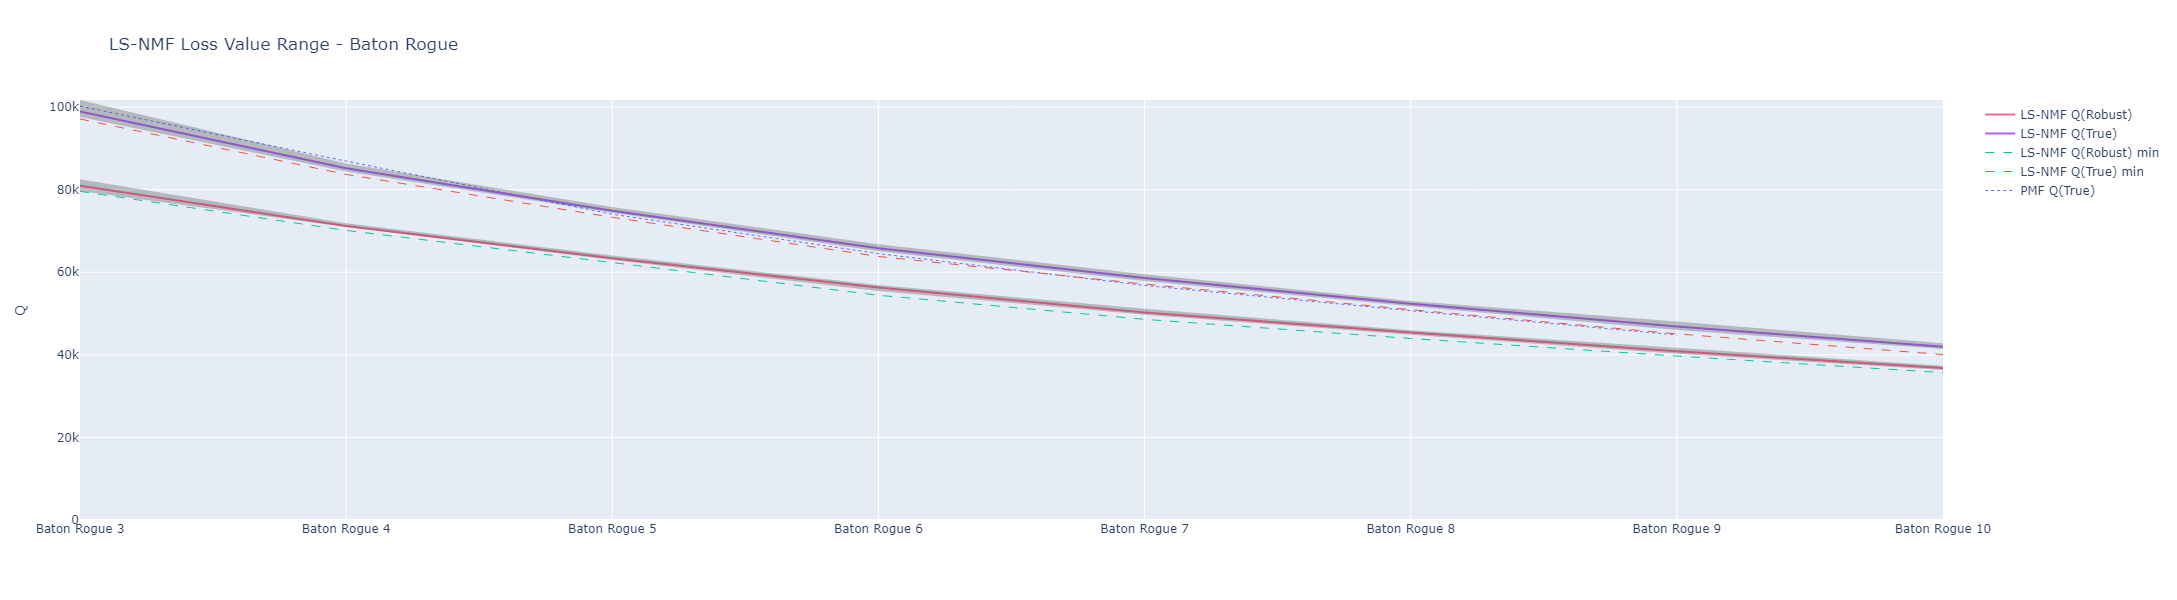

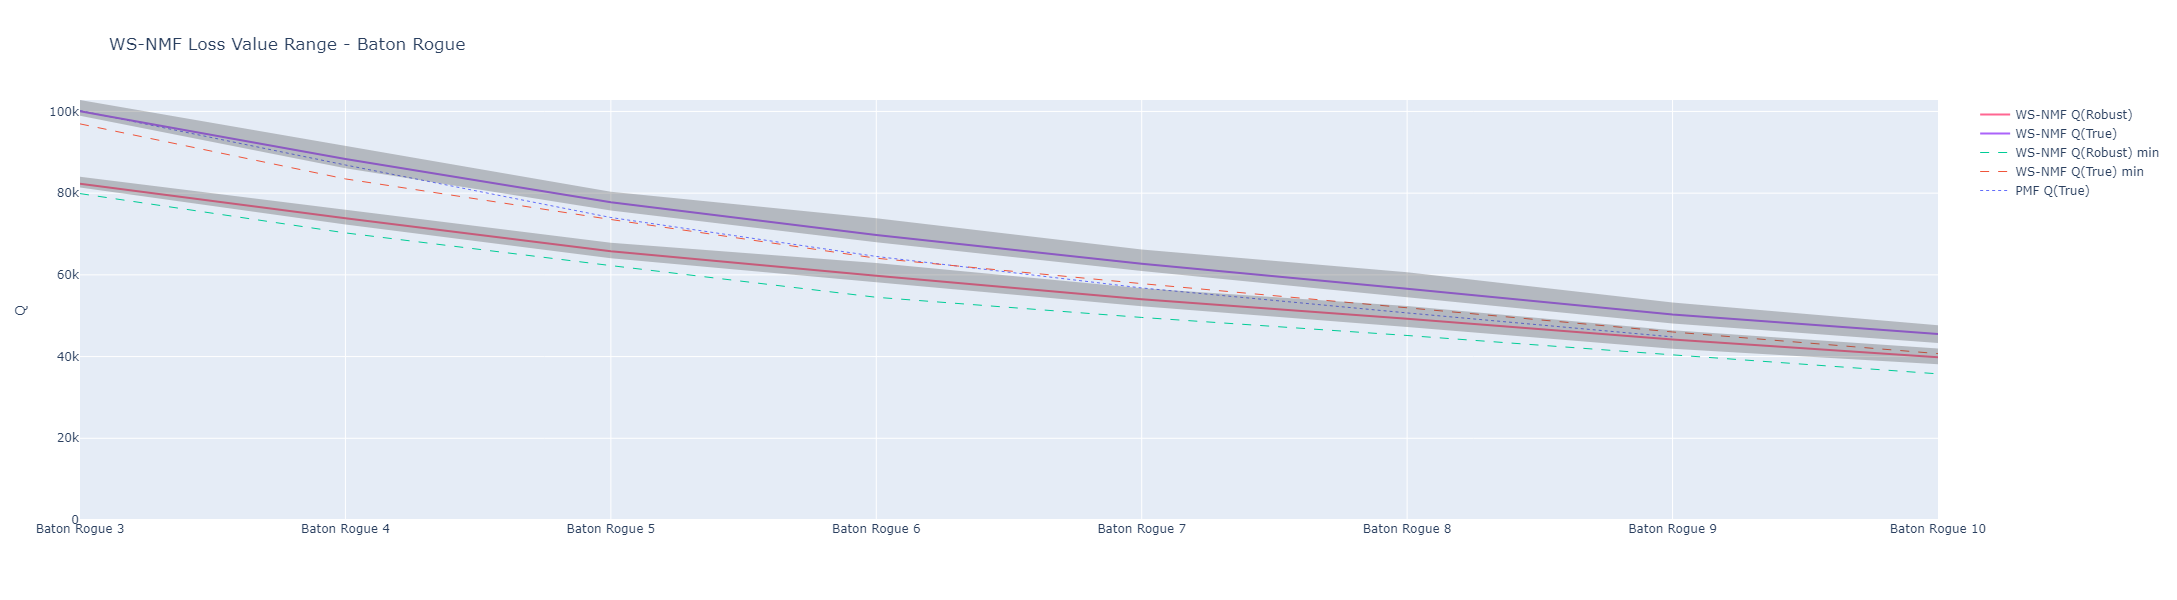

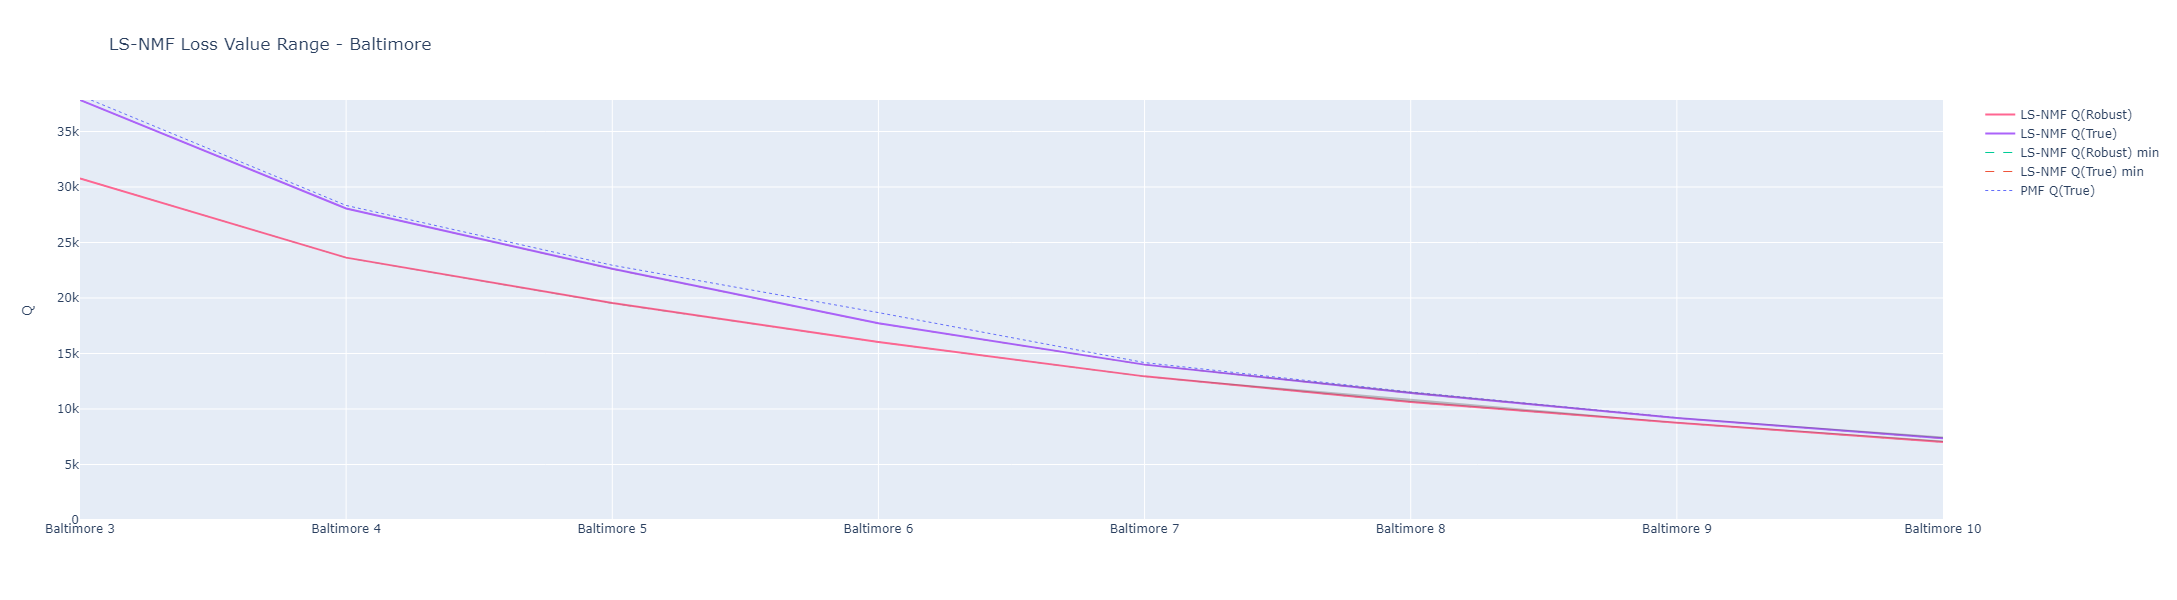

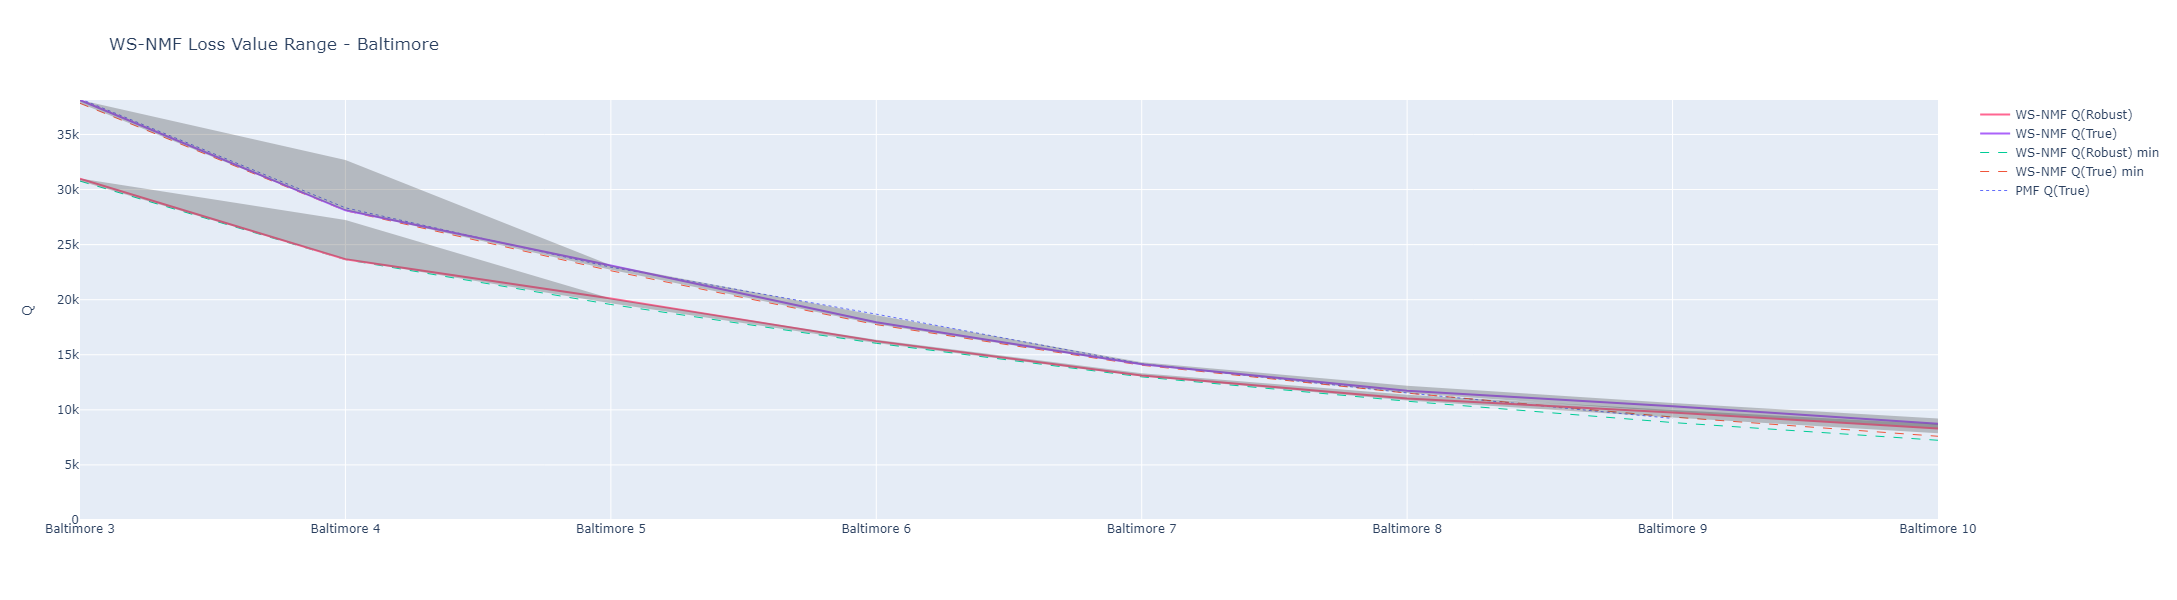

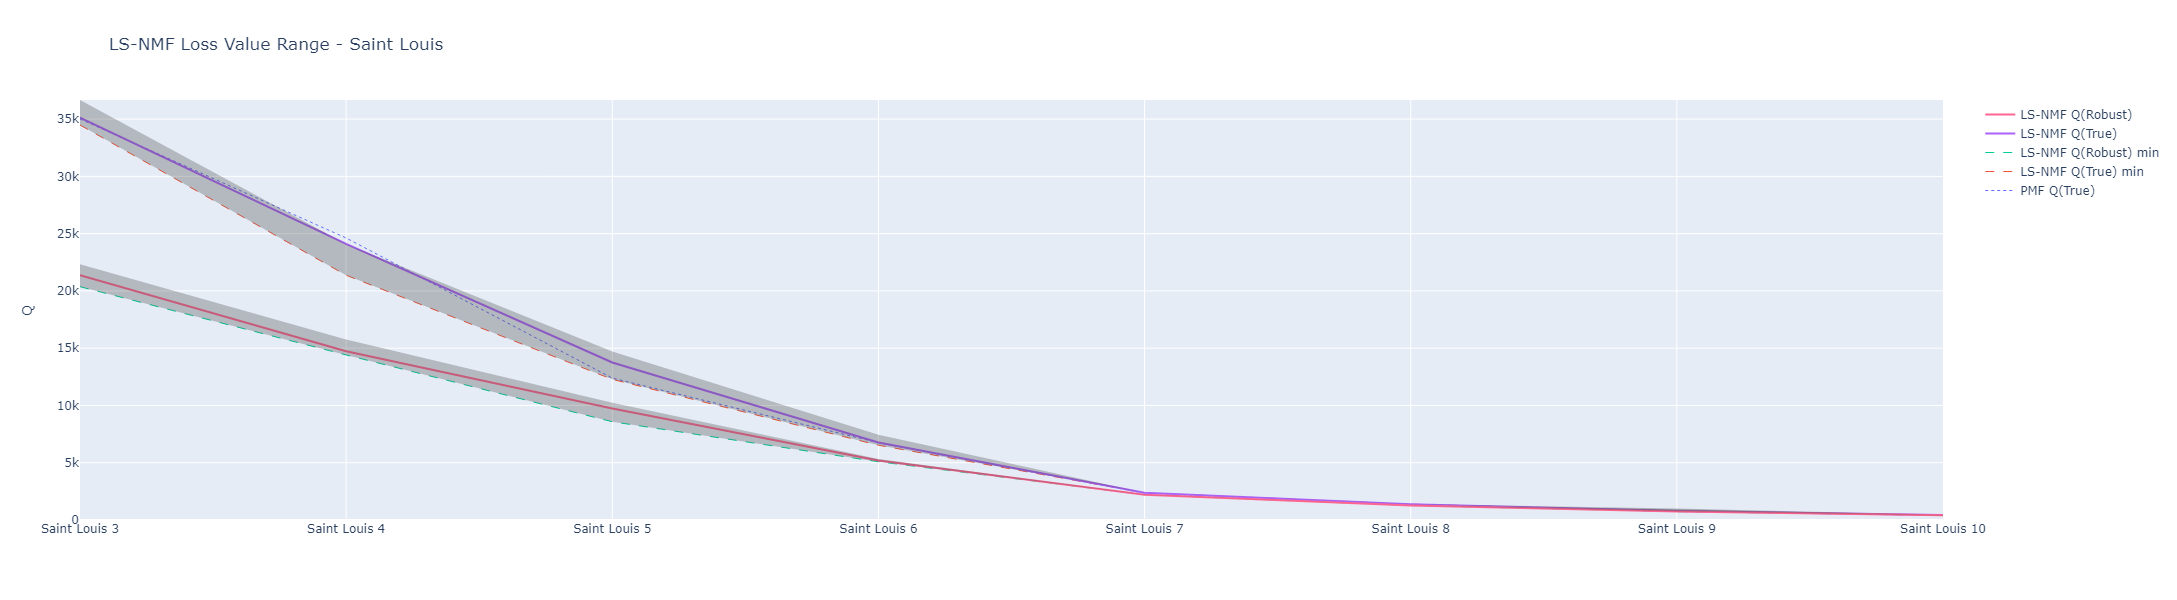

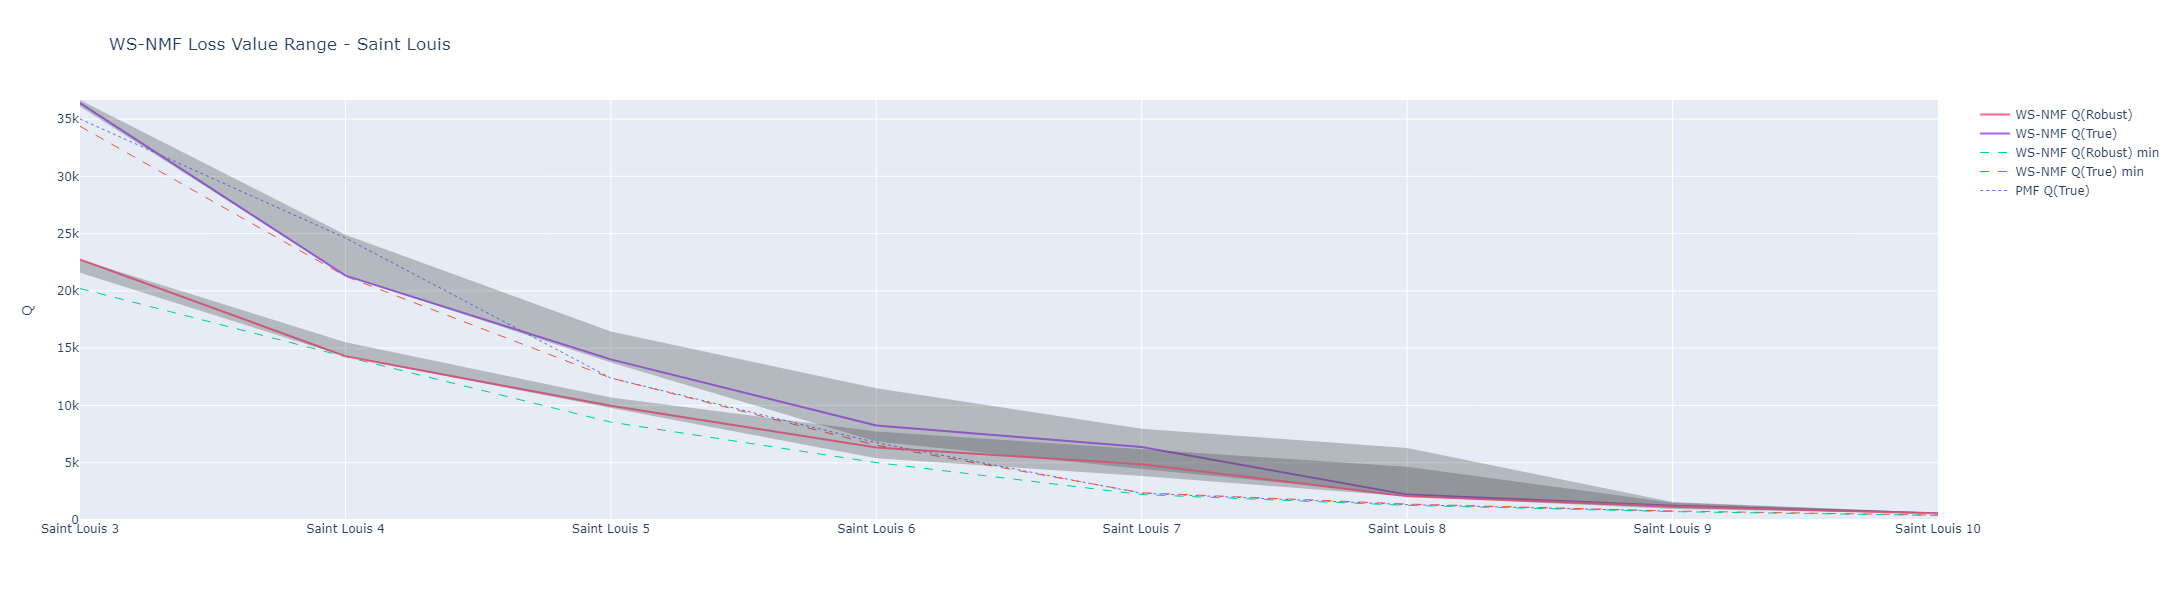

In [10]:
for dataset_i in ["Baton Rogue", "Baltimore", "Saint Louis"]:
    d1 = q_df2.loc[q_df2['dataset']==dataset_i]
    # q_sub = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05, subplot_titles=("LS-NMF", "WS-NMF"))
    q_fig1 = go.Figure()

    t0_a = d1.iloc[0]['ls-nmf Q(True) q3']
    t0_b = d1.iloc[0]['ws-nmf Q(True) q3']

    q_fig1.add_trace(go.Scatter(name="PMF Q(True)", x=d1['labels'], y=d1['pmf Q(True)'], mode='lines', line=dict(width=1, dash='dot')))
    q_fig1.add_trace(go.Scatter(name="LS-NMF Q(True) min", x=d1['labels'], y=d1['ls-nmf Q(True) min'], mode='lines', line=dict(width=1, dash='dash')))
    q_fig1.add_trace(go.Scatter(name="LS-NMF Q(Robust) min", x=d1['labels'], y=d1['ls-nmf Q(Robust) min'], mode='lines', line=dict(width=1, dash='dash')))
    
    q_fig1.add_trace(go.Scatter(name="LS-NMF Q(True)", x=d1['labels'], y=d1['ls-nmf Q(True)'], mode='lines'))
    q_fig1.add_trace(go.Scatter(name="LS-NMF Q3", x=d1['labels'], y=d1['ls-nmf Q(True) q3'], mode='lines', line=dict(width=0), marker=dict(color='#444'), showlegend=False))
    q_fig1.add_trace(go.Scatter(name="LS-NMF Q1", x=d1['labels'], y=d1['ls-nmf Q(True) q1'], mode='lines', line=dict(width=0), marker=dict(color='#444'), fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False))
    
    q_fig1.add_trace(go.Scatter(name="LS-NMF Q(Robust)", x=d1['labels'], y=d1['ls-nmf Q(Robust)'], mode='lines'))
    q_fig1.add_trace(go.Scatter(name="LS-NMF Q3", x=d1['labels'], y=d1['ls-nmf Q(Robust) q3'], mode='lines', line=dict(width=0), marker=dict(color='#444'), showlegend=False))
    q_fig1.add_trace(go.Scatter(name="LS-NMF Q1", x=d1['labels'], y=d1['ls-nmf Q(Robust) q1'], mode='lines', line=dict(width=0), marker=dict(color='#444'), fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False))
    
    q_fig2 = go.Figure()
    q_fig2.add_trace(go.Scatter(name="PMF Q(True)", x=d1['labels'], y=d1['pmf Q(True)'], mode='lines', line=dict(width=1, dash='dot')))
    q_fig2.add_trace(go.Scatter(name="WS-NMF Q(True) min", x=d1['labels'], y=d1['ws-nmf Q(True) min'], mode='lines', line=dict(width=1, dash='dash')))
    q_fig2.add_trace(go.Scatter(name="WS-NMF Q(Robust) min", x=d1['labels'], y=d1['ws-nmf Q(Robust) min'], mode='lines', line=dict(width=1, dash='dash')))
    
    q_fig2.add_trace(go.Scatter(name="WS-NMF Q(True)", x=d1['labels'], y=d1['ws-nmf Q(True)'], mode='lines'))
    q_fig2.add_trace(go.Scatter(name="WS-NMF Q3", x=d1['labels'], y=d1['ws-nmf Q(True) q3'], mode='lines', line=dict(width=0), marker=dict(color='#444'), showlegend=False))
    q_fig2.add_trace(go.Scatter(name="WS-NMF Q1", x=d1['labels'], y=d1['ws-nmf Q(True) q1'], mode='lines', line=dict(width=0), marker=dict(color='#444'), fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False))
    
    q_fig2.add_trace(go.Scatter(name="WS-NMF Q(Robust)", x=d1['labels'], y=d1['ws-nmf Q(Robust)'], mode='lines'))
    q_fig2.add_trace(go.Scatter(name="WS-NMF Q3", x=d1['labels'], y=d1['ws-nmf Q(Robust) q3'], mode='lines', line=dict(width=0), marker=dict(color='#444'), showlegend=False))
    q_fig2.add_trace(go.Scatter(name="WS-NMF Q1", x=d1['labels'], y=d1['ws-nmf Q(Robust) q1'], mode='lines', line=dict(width=0), marker=dict(color='#444'), fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False))

    q_fig1.update_layout(width=1000, height=600, title=f"LS-NMF Loss Value Range - {dataset_i}", hovermode="x")
    q_fig2.update_layout(width=1000, height=600, title=f"WS-NMF Loss Value Range - {dataset_i}", hovermode="x")

    q_fig1.update_yaxes(title_text="Q", range=[0, t0_a])
    q_fig2.update_yaxes(title_text="Q", range=[0, t0_b])
    q_fig1.show()
    q_fig2.show()

In [11]:
runtime_file = os.path.join("..", "eval", "results", "type_runtime_analysis.json")

runtime_json = {}
with open(runtime_file, 'r') as p_file:
    runtime_json = json.load(p_file)
runtime_df = pd.DataFrame(runtime_json.values())

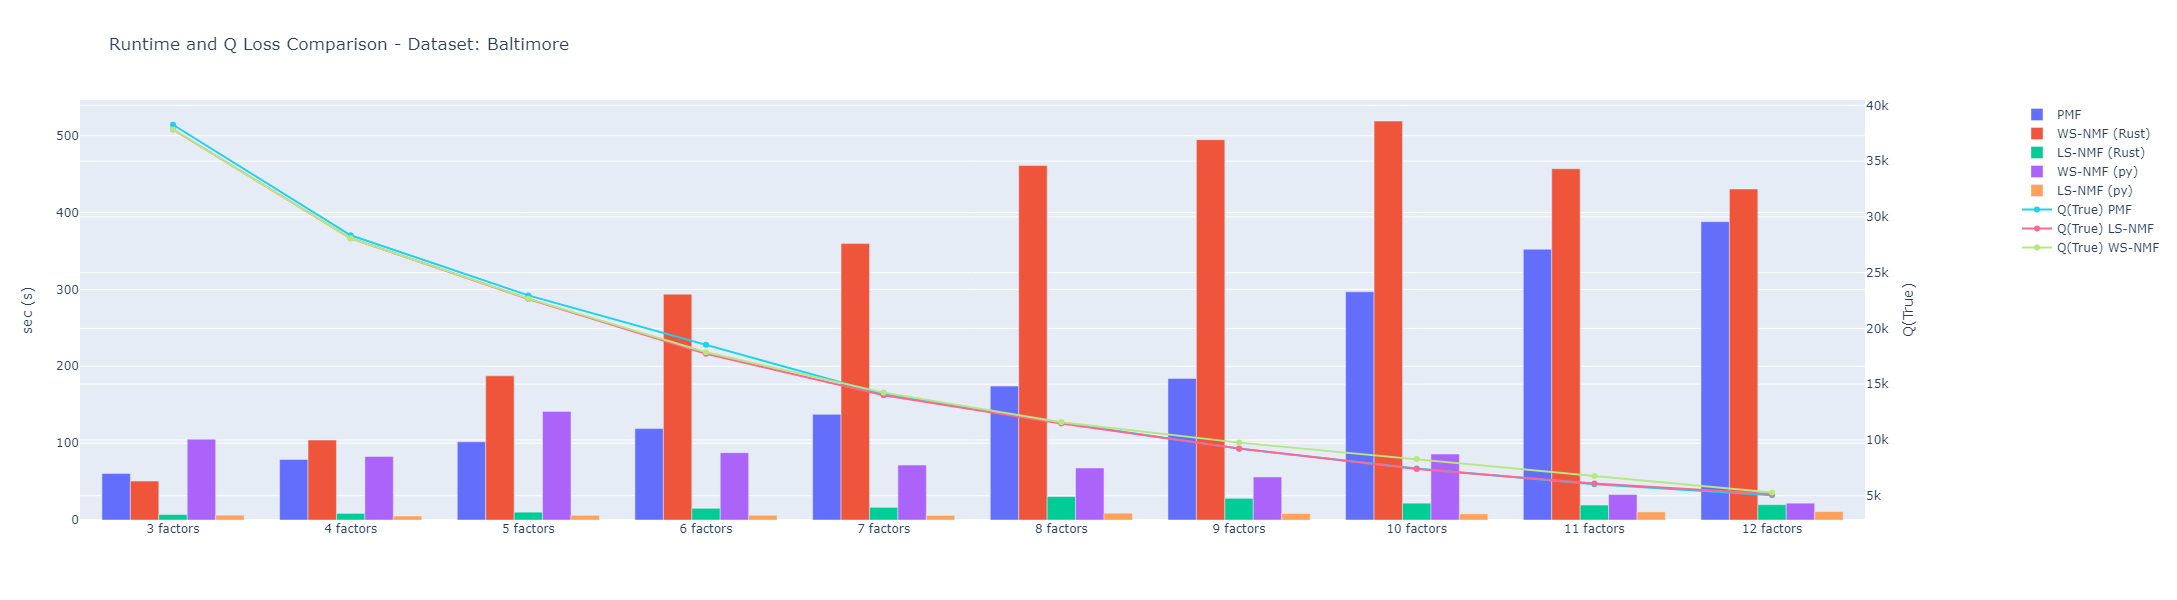

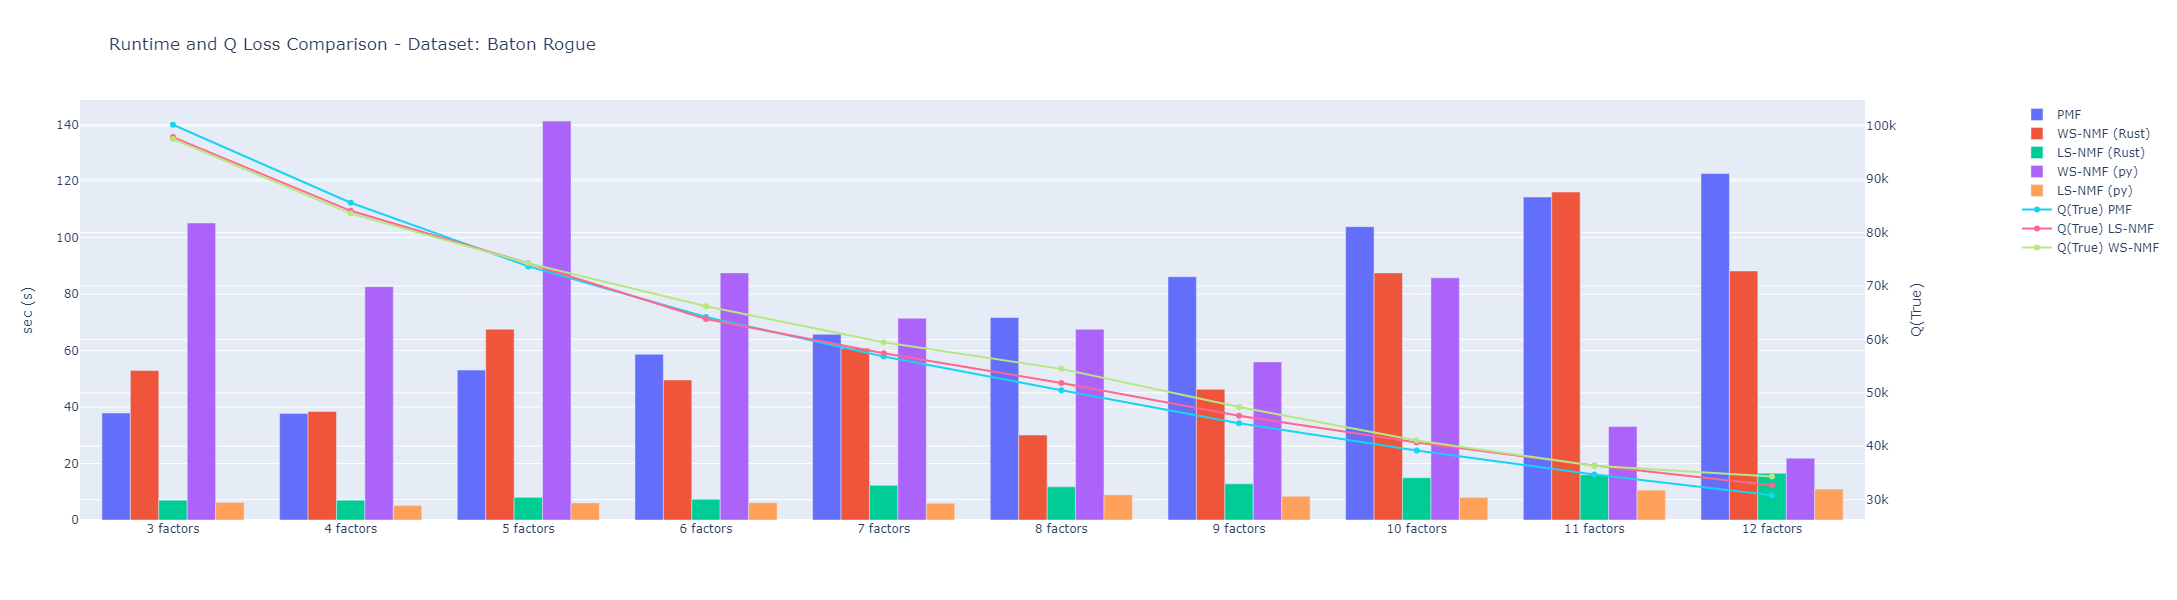

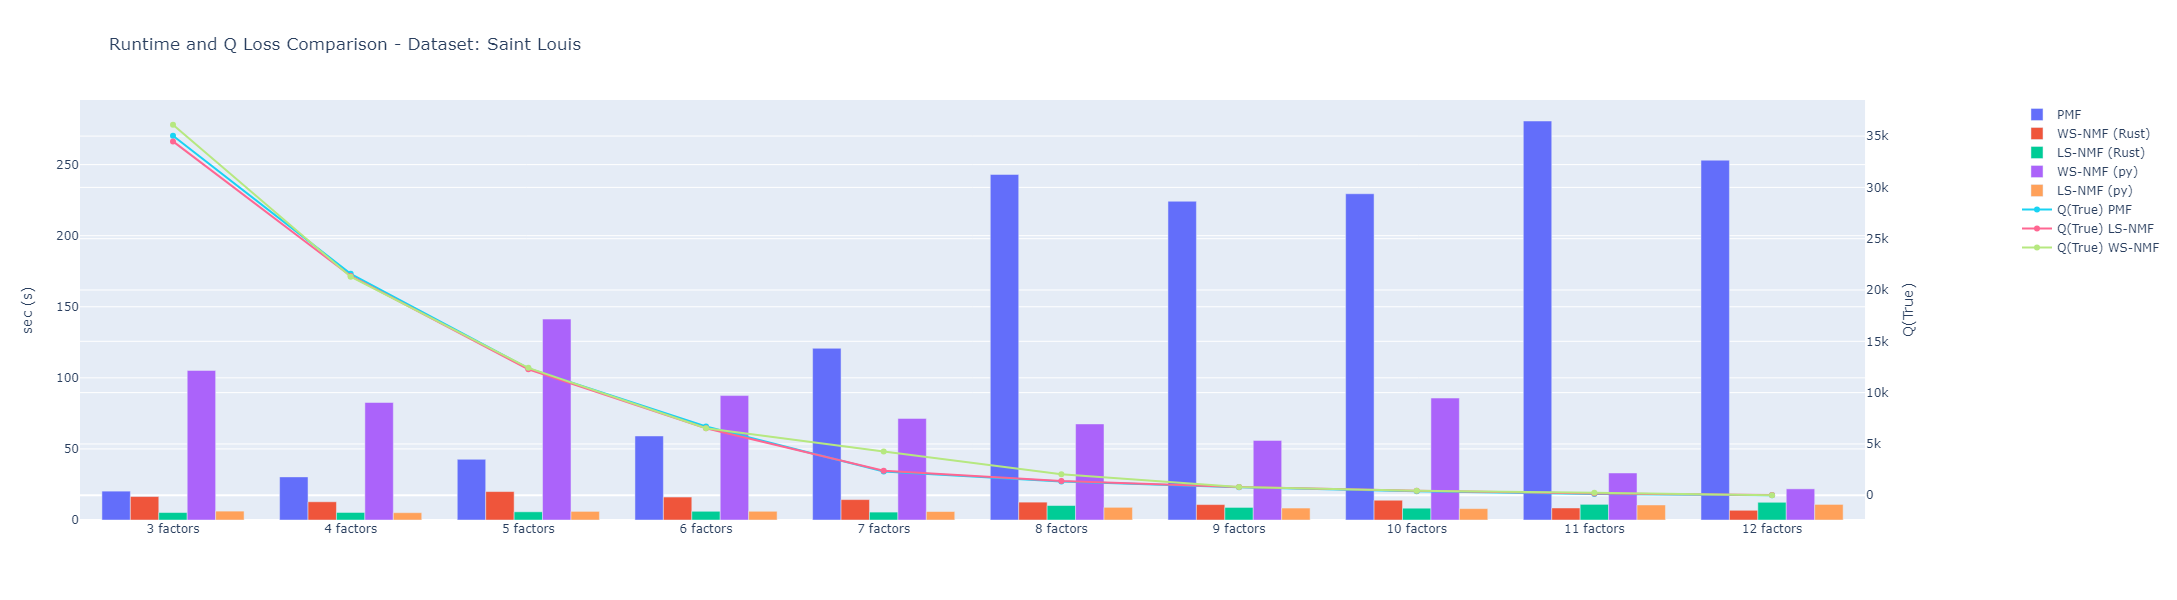

In [17]:
for dataset in ["b", "br", "sl"]:
    d_title = ""
    if dataset == "b":
        d_title = "Baltimore"
    elif dataset == "br":
        d_title = "Baton Rogue"
    else:
        d_title = "Saint Louis"
    i_df = runtime_df.loc[runtime_df["dataset"]==dataset]
    i_df = i_df.sort_values(by = ['factors'], ascending=[True])
    
    labels = i_df["factors"].astype(str) + " factors"
    i_df["index"] = labels

    i_sub = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])

    pmf_trace = go.Bar(x=labels, y=i_df["pmf-runtime"], name="PMF")
    ws_trace1 = go.Bar(x=labels, y=i_df["ws-nmf-rust-runtime"], name="WS-NMF (Rust)")
    # ws_trace2 = go.Bar(x=labels, y=i_df["ws-nmf-py-runtime"], name="WS-NMF (py)")
    ls_trace1 = go.Bar(x=labels, y=i_df["ls-nmf-rust-runtime"], name="LS-NMF (Rust)")
    # ls_trace2 = go.Bar(x=labels, y=i_df["ls-nmf-py-runtime"], name="LS-NMF (py)")
    i_sub.add_trace(pmf_trace, secondary_y=False)
    i_sub.add_trace(ws_trace1, secondary_y=False)
    i_sub.add_trace(ls_trace1, secondary_y=False)
    i_sub.add_trace(ws_trace2, secondary_y=False)
    i_sub.add_trace(ls_trace2, secondary_y=False)

    # ws_trace0 = go.Bar(x=labels, y=i_df["ws-nmf-runtime"], name="WS-NMF (Orig)")
    # ls_trace0 = go.Bar(x=labels, y=i_df["ls-nmf-runtime"], name="LS-NMF (Orig)")
    # i_sub.add_trace(ws_trace0, secondary_y=False)
    # i_sub.add_trace(ls_trace0, secondary_y=False)

    pmf_trace2= go.Scatter(x=labels, y=i_df["pmf-Q"], name="Q(True) PMF", mode='lines+markers')    
    ws_trace3 = go.Scatter(x=labels, y=i_df["ws-nmf-Q"], name="Q(True) WS-NMF", mode='lines+markers')
    ls_trace3 = go.Scatter(x=labels, y=i_df["ls-nmf-Q"], name="Q(True) LS-NMF", mode='lines+markers')
    
    i_sub.add_trace(pmf_trace2, secondary_y=True)
    i_sub.add_trace(ls_trace3, secondary_y=True)
    i_sub.add_trace(ws_trace3, secondary_y=True)

    i_sub.update_yaxes(title_text="sec (s)", secondary_y=False)
    i_sub.update_yaxes(title_text="Q(True)", secondary_y=True)
    i_sub.update_layout(height=600, width=1200, title_text=f"Runtime and Q Loss Comparison - Dataset: {d_title}", hovermode="x")
    i_sub.show()

In [13]:
runtime_file2 = os.path.join("..", "eval", "results", "type_runtime_analysis2.json")

runtime_json2 = {}
with open(runtime_file2, 'r') as p_file:
    runtime_json2 = json.load(p_file)
runtime_df2 = pd.DataFrame(runtime_json2.values())

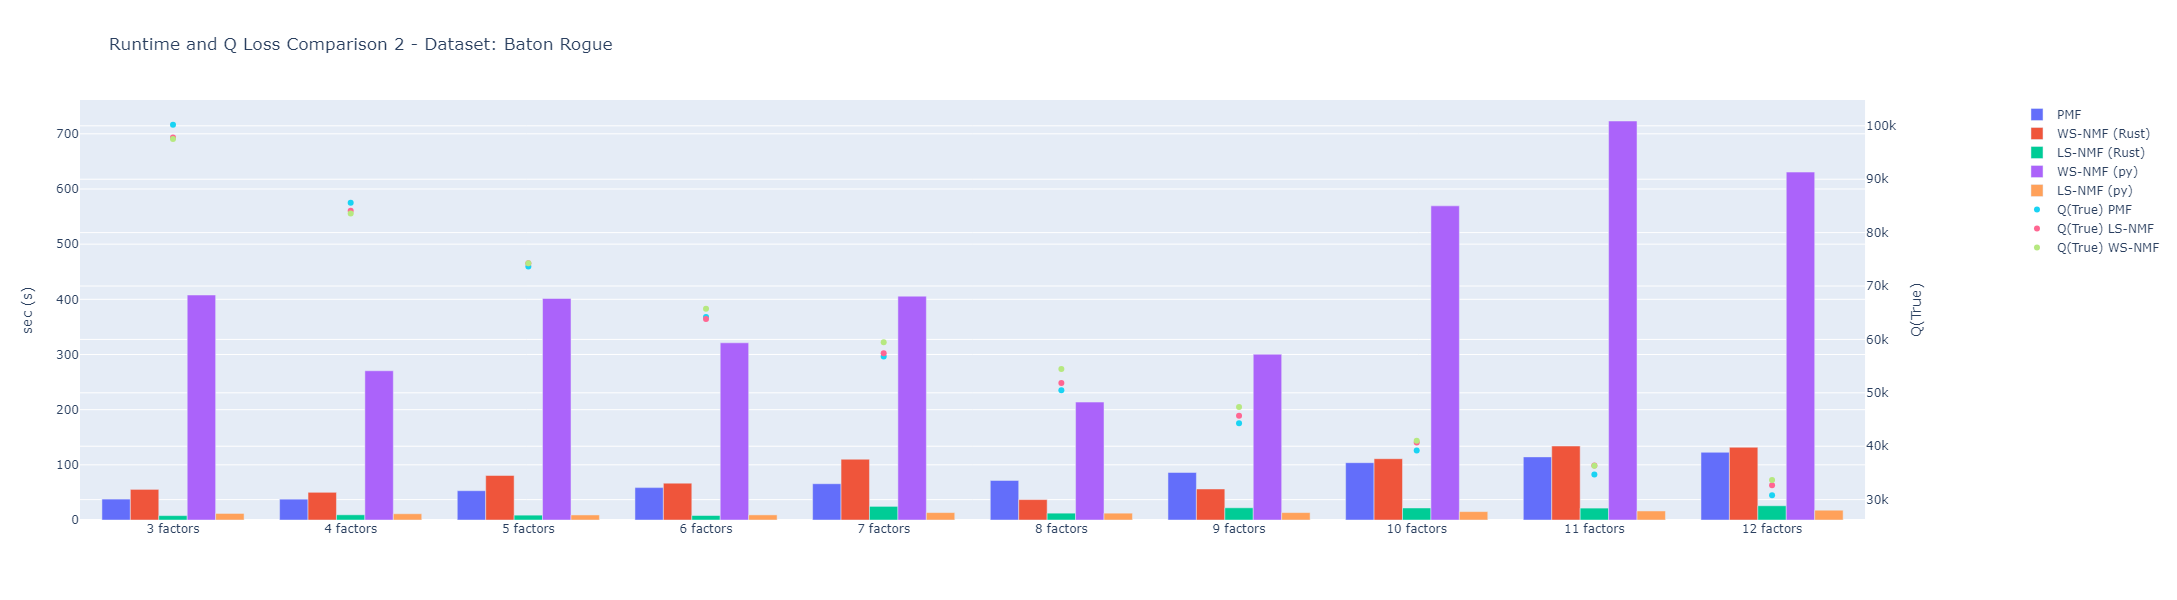

In [14]:
for dataset in ["br", "b", "sl"]:
    d_title = ""
    if dataset == "b":
        d_title = "Baltimore"
    elif dataset == "br":
        d_title = "Baton Rogue"
    else:
        d_title = "Saint Louis"
    i_df = runtime_df2.loc[runtime_df["dataset"]==dataset]
    i_df = i_df.sort_values(by = ['factors'], ascending=[True])
    
    labels = i_df["factors"].astype(str) + " factors"
    i_df["index"] = labels

    i_sub = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])

    pmf_trace = go.Bar(x=labels, y=i_df["pmf-runtime"], name="PMF")
    ws_trace1 = go.Bar(x=labels, y=i_df["ws-nmf-rust-runtime"], name="WS-NMF (Rust)")
    ws_trace2 = go.Bar(x=labels, y=i_df["ws-nmf-py-runtime"], name="WS-NMF (py)")
    ls_trace1 = go.Bar(x=labels, y=i_df["ls-nmf-rust-runtime"], name="LS-NMF (Rust)")
    ls_trace2 = go.Bar(x=labels, y=i_df["ls-nmf-py-runtime"], name="LS-NMF (py)")
    i_sub.add_trace(pmf_trace, secondary_y=False)
    i_sub.add_trace(ws_trace1, secondary_y=False)
    i_sub.add_trace(ls_trace1, secondary_y=False)
    i_sub.add_trace(ws_trace2, secondary_y=False)
    i_sub.add_trace(ls_trace2, secondary_y=False)

    pmf_trace2= go.Scatter(x=labels, y=i_df["pmf-Q"], name="Q(True) PMF", mode='markers')    
    ws_trace3 = go.Scatter(x=labels, y=i_df["ws-nmf-Q"], name="Q(True) WS-NMF", mode='markers')
    ls_trace3 = go.Scatter(x=labels, y=i_df["ls-nmf-Q"], name="Q(True) LS-NMF", mode='markers')
    
    i_sub.add_trace(pmf_trace2, secondary_y=True)
    i_sub.add_trace(ls_trace3, secondary_y=True)
    i_sub.add_trace(ws_trace3, secondary_y=True)

    i_sub.update_yaxes(title_text="sec (s)", secondary_y=False)
    i_sub.update_yaxes(title_text="Q(True)", secondary_y=True)
    i_sub.update_layout(height=600, width=1200, title_text=f"Runtime and Q Loss Comparison 2 - Dataset: {d_title}", hovermode="x")
    i_sub.show()